In [1]:
import os
import math

import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import random

In [2]:
#global variables
maxT = 37
maxLambda = 800
PAD_VALUE = -1
NEvts = 1000
pi = 3.141592653589793

In [3]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences

class MyGenerator(Sequence):
    def __init__(self, x_dir, batch_size):
        self.x_dir = x_dir
        self.x = os.listdir(x_dir)
        self.batch_size = batch_size
        print('Generator init complete')
        
    def __len__(self):
        nf = self.batch_size/(NEvts) # calculate number of files
        return math.ceil(len(self.x) / nf)

    def __getitem__(self, idx):
        batch_data = np.load(os.path.join(self.x_dir, self.x[idx]))
        Y = np.array(batch_data['y'])
        ####Y = np.delete(Y,np.s_[-3:],1)
        #Y = np.delete(Y,0,1)
        #print(Y.shape,'  1  ',Y)
        #print(Y[:,0].shape, ' <-test ')
        #Y = np.hstack(( np.sin(Y[:,0]).reshape(1000,1), np.cos(Y[:,0]).reshape(1000,1), np.sin(Y[:,1]).reshape(1000,1), np.cos(Y[:,1]).reshape(1000,1), Y[:,2].reshape(1000,1) ))
        #print(Y.shape,'   2 ',Y)
        return np.array(batch_data['x']), Y

Using TensorFlow backend.


In [4]:
training_generator = MyGenerator('/data/Elagin/vtx_xyz_nocolor_train_norm', NEvts)

testing_generator = MyGenerator('/data/Elagin/vtx_xyz_nocolor_test_norm', NEvts)

Generator init complete
Generator init complete


In [5]:

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda, Input, Concatenate, concatenate
from keras.layers import Conv1D, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling1D, MaxPooling2D, LocallyConnected2D, LocallyConnected1D
from keras.layers import LSTM, Bidirectional
from keras.layers import Masking
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import keras.backend as K

In [6]:
def mapping_to_pmOne(x) :
    return 2*K.sigmoid(x) - 1

def mapping_to_pm50(x) :
    return mapping_to_pmOne(x)*50


def mapping_to_0_50(x) :
    return 50*K.sigmoid(x)


def mapping_to_target_range_all( x, target_min=-0.02*pi, target_max=2.02*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

def mapping_to_target_range_2pi( x, target_min=-0.00*pi, target_max=2.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_pi( x, target_min=-0.00*pi, target_max=1.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_phi( x, target_min=0, target_max=2*pi ) :
    print('is x keras tensor:', K.is_keras_tensor(x))
    print('x shape = ',K.int_shape(x))
    print('x shape = ',K.shape(x))
    #phi = K.placeholder(shape=(None,1))
    phi = Input([1])
    #theta = K.placeholder(shape=(None,1))
    theta = Input([1])
    #r = K.placeholder(shape=(None,1))
    r = Input([1])
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    phi = K.concatenate([phi, [K.tanh(x[:,1]) + 1]], axis=0) # x in range(0,2)
    #phi = K.tanh(x[:,1]) + 1
    theta = K.concatenate([theta, [x[:,0]]], axis=0)
    #theta = x[:,0]
    r = K.concatenate([r, [x[:,2]]], axis=0)
    #r = x[:,2]
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    print('theta shape = ',K.int_shape(theta))
    print('r shape = ',K.int_shape(r))
    scale = ( target_max-target_min )/2.
    phi =  phi * scale + target_min
    #phi = K.cast(phi, dtype='int32')
    #phi = K.reshape(phi, (,1))
    print('phi shape = ',K.int_shape(phi))
    
    res = K.concatenate([theta, phi, r], axis=1)
    print('res shape = ',K.int_shape(res))
    print('res shape = ',K.shape(res))
    print('is res keras tensor:', K.is_keras_tensor(res))
    x[:,1].assign(phi)
    return x

def mapping_to_target_range_phi2( x, target_min=0, target_max=2*pi ) :
    scale = ( target_max-target_min )/2.
    phi = K.placeholder(shape=(None,1))
    #phi = Input([1])
    #phi = (K.tanh(x[:,1]) + 1)*scale + target_min
    phi = K.concatenate([phi, [(K.tanh(x[:,1]) + 1)*scale + target_min]], axis=0)
    x[:,1].assign(phi)
    return x

In [18]:
### This is a test cell. Go to LSTM cell below
def createModel():
    #model = Sequential()
    in_put = Input(shape=(3300,))
    
    layer1 = Dense(2048, activation='relu')(in_put)
    layer2 = Dense(1024, activation='relu')(layer1)
    layer2 = Dropout(0.05)(layer2)
    layer3 = Dense(512, activation='relu')(layer2)
    layer3 = Dropout(0.03)(layer3)
    layer4 = Dense(64, activation='relu')(layer3)
    layer4 = Dropout(0.03)(layer4)
    out_put = Dense(5, activation=None)(layer4)
    
    sinT = Lambda(lambda x: x[:,0], output_shape=(1,))(out_put)
    sinT = Activation(activation='sigmoid')(sinT)
    cosT = Lambda(lambda x: x[:,1], output_shape=(1,))(out_put)
    cosT = Activation(activation=mapping_to_pmOne)(cosT)
    
    sinP = Lambda(lambda x: x[:,2], output_shape=(1,))(out_put)
    sinP = Activation(activation=mapping_to_pmOne)(sinP)
    cosP = Lambda(lambda x: x[:,3], output_shape=(1,))(out_put)
    cosP = Activation(activation=mapping_to_pmOne)(cosP)
   
    r = Lambda(lambda x: x[:,4], output_shape=(1,))(out_put)
    r = Activation(activation=mapping_to_0_50)(r)

    print('sinP shape = ',K.int_shape(sinP))
    print('is sinP keras tensor:', K.is_keras_tensor(sinP))
    print('r shape = ',K.int_shape(r))
    out_put_a = Lambda(lambda x: K.stack([x[0], x[1], x[2], x[3], x[4]], axis=1),output_shape=(5,),  name="output")([sinT, cosT, sinP, cosP, r])
    print('is out_put_a keras tensor:', K.is_keras_tensor(out_put_a))
    print('out_put_a shape = ',K.int_shape(out_put_a))
    print('out_put_a shape = ',K.shape(out_put_a))
    
    model = Model(inputs=in_put, outputs=out_put_a)
    return model

In [61]:
### This is a test cell. Go to LSTM model below
def createModel():
    #model = Sequential()
    in_put = Input(shape=(4400,))
    layer0 = Dense(1024, activation='relu')(in_put)
    layer0 = Dropout(0.25)(layer0)
    layer1 = Dense(1024, activation='relu')(layer0)
    layer1 = Dropout(0.25)(layer1)
    layer2 = Dense(512, activation='relu')(layer1)
    layer2 = Dropout(0.1)(layer2)
    layer3 = Dense(64, activation='relu')(layer2)
    #layer3 = Dropout(0.04)(layer3)
    out_put = Dense(3)(layer3)
    
    model = Model(inputs=in_put, outputs=out_put)
    return model

In [7]:
### This is the development LSTM model
def createModel():
    N=3300
    lstm_seq = 300
    lstm_steps = int(N/lstm_seq)
    model = Sequential()
    
    model.add(Reshape(input_shape=(N,), target_shape=(lstm_steps,lstm_seq)))
    
    model.add(Masking(mask_value=-1, input_shape=(lstm_steps, lstm_seq)))
    
    model.add(Bidirectional(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0)))
    model.add(Bidirectional(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0)))
    model.add(Bidirectional(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0)))
    model.add(Bidirectional(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0)))
    model.add(Bidirectional(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0)))
    model.add(Bidirectional(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0)))
    model.add(Bidirectional(LSTM(75, input_shape=(lstm_steps,lstm_seq), dropout=0.0)))
    
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(3, activation=mapping_to_pm50))
    
    return model

In [8]:
my_network=createModel()

In [9]:
my_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 11, 300)           0         
_________________________________________________________________
masking_1 (Masking)          (None, 11, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 11, 150)           225600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 11, 150)           135600    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 11, 150)           135600    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 11, 150)           135600    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 11, 150)          

In [ ]:
batch_size = NEvts
epochs = 2

def mean_abs_theta_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,0] - y_pred[:,0]))
def mean_abs_phi_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,1] - y_pred[:,1]))
def mean_abs_r_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,2] - y_pred[:,2]))
def mean_abs_theta_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,3] - y_pred[:,3]))
def mean_abs_phi_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,4] - y_pred[:,4]))


my_network.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error')#, 
                   #metrics=['mean_squared_error', mean_abs_theta_vtx, mean_abs_phi_vtx, mean_abs_r_vtx])#, 
                                                  #mean_abs_theta_dir, mean_abs_phi_dir])

my_network.load_weights("weights_vtx_only_nocolor_7xLSTM75_f552_lr1e-4_0p5mSphere_0p0ns_0p0nm_norm_N4epochs.h5")

history = my_network.fit_generator(generator=training_generator, epochs=epochs, 
                    validation_data=testing_generator) 


In [11]:
my_network.save_weights("weights_vtx_only_nocolor_7xLSTM75_f552_lr1e-4_0p5mSphere_0p0ns_0p0nm_norm_N5epochs.h5")

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

In [13]:
def load_test_data_to_memory(x_dir) :
    X, Y = np.array([]), np.array([])
    f_list = os.listdir(x_dir)
    for x in f_list :
        batch_data = np.load(os.path.join(x_dir, x))
        #print(np.array(batch_data['x']).shape)
        #print(np.array(batch_data['y']).shape)
        #print(np.array(batch_data['y']))
        print(x)
        X = np.vstack([X, np.array(batch_data['x'])]) if X.size else np.array(batch_data['x'])
        Y = np.vstack([Y, np.array(batch_data['y'])]) if Y.size else np.array(batch_data['y'])
        #print(X.shape, '   ', Y.shape)
    #Y = np.hstack(( np.sin(Y[:,0]).reshape(10000,1), np.cos(Y[:,0]).reshape(10000,1), np.sin(Y[:,1]).reshape(10000,1), np.cos(Y[:,1]).reshape(10000,1), Y[:,2].reshape(10000,1) ))
    print(X.shape, '   ', Y.shape)
    return X, Y

In [14]:
testX, testY = load_test_data_to_memory('/data/Elagin/vtx_xyz_nocolor_test_norm/')

f_batch_18.npz
f_batch_16.npz
f_batch_11.npz
f_batch_9.npz
f_batch_7.npz
f_batch_10.npz
f_batch_17.npz
f_batch_19.npz
f_batch_1.npz
f_batch_6.npz
f_batch_8.npz
f_batch_5.npz
f_batch_2.npz
f_batch_14.npz
f_batch_13.npz
f_batch_3.npz
f_batch_4.npz
f_batch_20.npz
f_batch_12.npz
f_batch_15.npz
(20000, 3300)     (20000, 3)


shape recoY =  (20000, 3)    shape testY =  (20000, 3)
ThetaMean_vtx =  0.023316353658762126


(array([ 145.,  440.,  659.,  862., 1054., 1193., 1320., 1400., 1475.,
        1549., 1492., 1493., 1396., 1271., 1153., 1041.,  818.,  657.,
         410.,  172.]),
 array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
          5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.]),
 <a list of 1 Patch objects>)

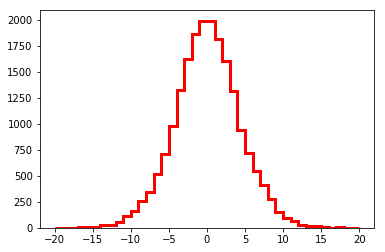

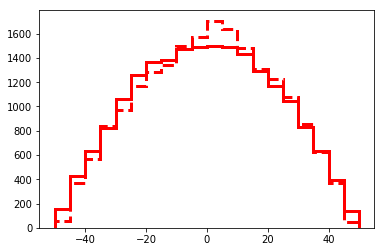

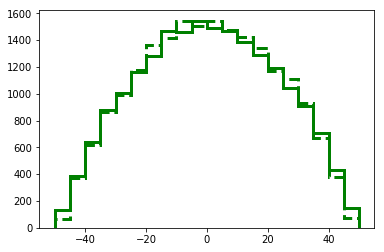

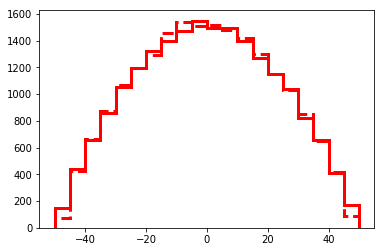

In [15]:
recoY = my_network.predict(testX)

print('shape recoY = ', recoY.shape, '   shape testY = ', testY.shape)


dTheta_vtx = recoY[:,1] - testY[:,1]
print('ThetaMean_vtx = ',np.mean(dTheta_vtx))

fig1 = plt.figure()
plt.hist(dTheta_vtx, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

fig_sinT = plt.figure()
plt.hist(recoY[:,0], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,0], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

fig_cosT = plt.figure()
plt.hist(recoY[:,1], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
plt.hist(testY[:,1], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')

fig_sinP = plt.figure()
plt.hist(recoY[:,2], bins=20, range=(-50,50), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,2], bins=20, range=(-50,50), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')

#fig_cosP = plt.figure()
#plt.hist(recoY[:,3], bins=20, range=(-12,12), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
#plt.hist(testY[:,3], bins=20, range=(-12,12), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')


#fig_R = plt.figure()
#plt.hist(np.abs(recoY[:,4]), bins=20, range=(0,60), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'b')
#plt.hist(testY[:,4], bins=20, range=(0,60), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
